In [ ]:
!pip install einops ninja gdown click scipy tensorboard
import os
import shutil
import random
from PIL import Image
import numpy as np

In [ ]:
# ====================
# Configuration
# ====================
DATASET = {
"name": "stylegan_chest_750",
"path": "/kaggle/input/chest-xray-pneumonia/chest_xray",
"res": "256x256"  # Preprocessing resolution
}
# Training configuration for 250 images only
NUM_IMAGES = 750
EPOCHS = 100
kimg = (NUM_IMAGES * EPOCHS) // 1000
print(f"Training Config: Epochs={EPOCHS}, Images={NUM_IMAGES}, kimg={kimg}")

Training Config: Epochs=100, Images=750, kimg=75


In [ ]:
# ====================
# Setup StyleGAN3
# ====================
model_dir = f"/kaggle/working/Results/{DATASET['name']}/model"
os.makedirs(model_dir, exist_ok=True)
if not os.path.exists(os.path.join(model_dir, "stylegan3")):
    !git clone https://github.com/NVlabs/stylegan3 {model_dir}/stylegan3
stylegan3_path = os.path.join(model_dir, "stylegan3")
os.chdir(stylegan3_path)

Cloning into '/kaggle/working/Results/stylegan_chest_750/model/stylegan3'...
remote: Enumerating objects: 212, done.
remote: Counting objects: 100% (166/166), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 212 (delta 101), reused 96 (delta 96), pack-reused 46 (from 1)
Receiving objects: 100% (212/212), 4.16 MiB | 35.80 MiB/s, done.
Resolving deltas: 100% (107/107), done.


In [ ]:
# ====================
# Preprocess Dataset (250 images) - SPLIT A
# ====================
# First, split the training data into two parts
base_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray'
train_dir = os.path.join(base_dir, 'train')
# Get all image paths from train directory
def get_image_paths(directory_path):
    image_paths = []
    for root, _, files in os.walk(directory_path):
        for file in files:
            if file.startswith("._") or file.startswith("."):
                continue
            if file.lower().endswith(('.png', '.jpeg', '.jpg')):
                image_paths.append(os.path.join(root, file))
    return image_paths

all_train_images = get_image_paths(train_dir)

In [ ]:
# Split into two parts: 80% for GAN training (Split A), 20% for downstream baseline (Split B)
random.seed(42)
random.shuffle(all_train_images)
split_idx = int(len(all_train_images) * 0.8)
split_a_images = all_train_images[:split_idx]  # For GAN training
split_b_images = all_train_images[split_idx:]  # For downstream baseline

print(f"Total training images: {len(all_train_images)}")
print(f"Split A (GAN training): {len(split_a_images)} images")
print(f"Split B (Downstream baseline): {len(split_b_images)} images")

Total training images: 5216
Split A (GAN training): 4172 images
Split B (Downstream baseline): 1044 images


In [ ]:
# Preprocess Split A for GAN training
OUTPUT_DIR = f"/kaggle/working/Results/{DATASET['name']}/preprocessed"
os.makedirs(OUTPUT_DIR, exist_ok=True)

def sample_and_convert_images(image_paths, num_samples, output_dir):
    # Make sure we have a balanced dataset if possible
    pneumonia_images = [p for p in image_paths if 'PNEUMONIA' in p]
    normal_images = [p for p in image_paths if 'NORMAL' in p]

    # Sample from each class proportionally
    num_pneumonia = min(len(pneumonia_images), num_samples // 2)
    num_normal = min(len(normal_images), num_samples // 2)

    sampled_paths = random.sample(pneumonia_images, num_pneumonia) + random.sample(normal_images, num_normal)

    for image_path in sampled_paths:
        filename = os.path.basename(image_path)
        output_path = os.path.join(output_dir, filename)
        try:
            image = Image.open(image_path).convert("RGB")
            # Resize to target resolution
            image = image.resize((256, 256))
            image.save(output_path)
            print(f"Saved {filename} -> {output_path}")
        except Exception as e:
            print(f"    Skipped {filename}: {e}")
    return len(sampled_paths)

# Sample 250 images from Split A for GAN training
actual_count = sample_and_convert_images(split_a_images, NUM_IMAGES, OUTPUT_DIR)
print(f"Successfully processed {actual_count} images for GAN training")

Saved person328_virus_681.jpeg -> /kaggle/working/Results/stylegan_chest_750/preprocessed/person328_virus_681.jpeg
Saved person935_virus_1597.jpeg -> /kaggle/working/Results/stylegan_chest_750/preprocessed/person935_virus_1597.jpeg
Saved person1271_bacteria_3231.jpeg -> /kaggle/working/Results/stylegan_chest_750/preprocessed/person1271_bacteria_3231.jpeg
Saved person461_virus_950.jpeg -> /kaggle/working/Results/stylegan_chest_750/preprocessed/person461_virus_950.jpeg
Saved person1156_virus_1936.jpeg -> /kaggle/working/Results/stylegan_chest_750/preprocessed/person1156_virus_1936.jpeg
Saved person1527_bacteria_3988.jpeg -> /kaggle/working/Results/stylegan_chest_750/preprocessed/person1527_bacteria_3988.jpeg
Saved person1290_virus_2215.jpeg -> /kaggle/working/Results/stylegan_chest_750/preprocessed/person1290_virus_2215.jpeg
Saved person949_virus_1620.jpeg -> /kaggle/working/Results/stylegan_chest_750/preprocessed/person949_virus_1620.jpeg
Saved person1225_virus_2076.jpeg -> /kaggle/work

In [ ]:
# ====================
# Pack dataset to zip
# ====================
TEMP_DIR = f"/kaggle/working/Results/{DATASET['name']}/{actual_count}_preprocessed"
os.makedirs(TEMP_DIR, exist_ok=True)
all_images = [f for f in os.listdir(OUTPUT_DIR) if f.lower().endswith(('.png', '.jpeg', '.jpg'))]
divided_images = sorted(all_images)[:actual_count]
for image in divided_images:
    shutil.copy(os.path.join(OUTPUT_DIR, image), os.path.join(TEMP_DIR, image))
dest_file = f"/kaggle/working/Results/{DATASET['name']}/{actual_count}_images/preprocessed{DATASET['res']}.zip"
os.makedirs(os.path.dirname(dest_file), exist_ok=True)
!python dataset_tool.py \
  --source="{TEMP_DIR}" \
  --dest="{dest_file}" \
  --resolution={DATASET['res']}

100%|████████████████████████████████████████| 750/750 [00:02<00:00, 274.06it/s]


In [ ]:
# Auto-fix betas issue for PyTorch >=2.0
train_file = os.path.join(stylegan3_path, "train.py")
with open(train_file, "r") as f:
    content = f.read()
content = content.replace("betas=[0,0.99]", "betas=(0.0, 0.99)")
with open(train_file, "w") as f:
    f.write(content)
print("✔️ Patched betas in train.py")

✔️ Patched betas in train.py


In [ ]:
# ===================
# Start Training
# ===================
checkpoints_dir = f"/kaggle/working/Results/{DATASET['name']}/{actual_count}_images/checkpoints"
os.makedirs(checkpoints_dir, exist_ok=True)

training_data = dest_file

# Train without FID calculation to save time
!python train.py \
    --outdir="{checkpoints_dir}" \
    --cfg=stylegan3-t \
    --data="{training_data}" \
    --snap=10 \
    --gpus=1 \
    --batch=16 \
    --batch-gpu=16 \
    --gamma=16 \
    --mirror=1 \
    --kimg={kimg} \
    --metrics=none



Training options:
{
  "G_kwargs": {
    "class_name": "training.networks_stylegan3.Generator",
    "z_dim": 512,
    "w_dim": 512,
    "mapping_kwargs": {
      "num_layers": 2
    },
    "channel_base": 32768,
    "channel_max": 512,
    "magnitude_ema_beta": 0.9994456359721023
  },
  "D_kwargs": {
    "class_name": "training.networks_stylegan2.Discriminator",
    "block_kwargs": {
      "freeze_layers": 0
    },
    "mapping_kwargs": {},
    "epilogue_kwargs": {
      "mbstd_group_size": 4
    },
    "channel_base": 32768,
    "channel_max": 512
  },
  "G_opt_kwargs": {
    "class_name": "torch.optim.Adam",
    "betas": [
      0.0,
      0.99
    ],
    "eps": 1e-08,
    "lr": 0.0025
  },
  "D_opt_kwargs": {
    "class_name": "torch.optim.Adam",
    "betas": [
      0.0,
      0.99
    ],
    "eps": 1e-08,
    "lr": 0.002
  },
  "loss_kwargs": {
    "class_name": "training.loss.StyleGAN2Loss",
    "r1_gamma": 16.0
  },
  "data_loader_kwargs": {
    "pin_memory": true,
    "prefetch

# Generate 1000 images from 750 image (SYNTH_GAN750)

In [ ]:
# ===================
# Generate Sample Images (1000 images)
# ===================
# Find the latest checkpoint
checkpoint_files = []
for root, dirs, files in os.walk(checkpoints_dir):
    for file in files:
        if file.startswith("network-snapshot") and file.endswith(".pkl"):
            checkpoint_files.append(os.path.join(root, file))

if checkpoint_files:
    # Use the latest checkpoint
    latest_checkpoint = sorted(checkpoint_files)[-1]
    print(f"Using checkpoint: {latest_checkpoint}")

    gen_output_dir = f"/kaggle/working/Results/{DATASET['name']}/{actual_count}_images/generated_1000_images"
    os.makedirs(gen_output_dir, exist_ok=True)

    # Generate 1000 images (seeds 0 through 999)
    !python gen_images.py \
        --outdir={gen_output_dir} \
        --trunc=0.7 \
        --seeds=0-2999 \
        --network={latest_checkpoint}
else:
    print("No checkpoints found for generation")

Using checkpoint: /kaggle/working/Results/stylegan_chest_750/750_images/checkpoints/00000-stylegan3-t-preprocessed256x256-gpus1-batch16-gamma16/network-snapshot-000075.pkl
Loading networks from "/kaggle/working/Results/stylegan_chest_750/750_images/checkpoints/00000-stylegan3-t-preprocessed256x256-gpus1-batch16-gamma16/network-snapshot-000075.pkl"...
Generating image for seed 0 (0/3000) ...
Setting up PyTorch plugin "bias_act_plugin"... /usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Done.
Setting up PyTorch plugin "filtered_lrelu_plugin"... /usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH

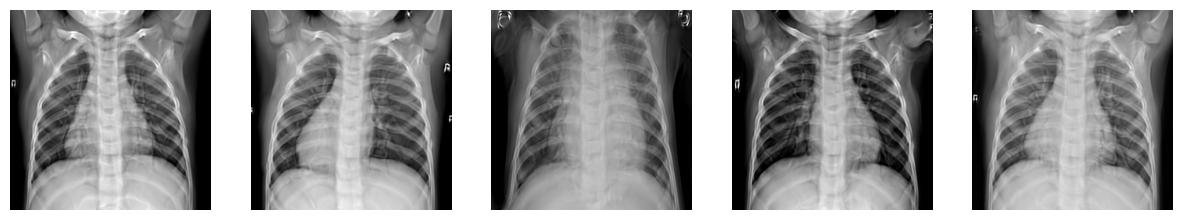

In [ ]:
import matplotlib.pyplot as plt
import os
from PIL import Image

# Pick some generated images
sample_images = sorted([f for f in os.listdir(gen_output_dir) if f.endswith(".png")])[:5]

# Display them
plt.figure(figsize=(15, 3))
for i, img_name in enumerate(sample_images):
    img_path = os.path.join(gen_output_dir, img_name)
    img = Image.open(img_path)
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.axis("off")
plt.show()



# FID score calculation

In [ ]:


!python calc_metrics.py \
    --metrics=fid50k_full \
    --network="{NETWORK_PKL}" \
    --data="{DATASET_ZIP}" \
    --mirror=1

Loading network from "/kaggle/working/Results/stylegan_chest_750/750_images/checkpoints/00000-stylegan3-t-preprocessed256x256-gpus1-batch16-gamma16/network-snapshot-000075.pkl"...
Dataset options:
{
  "class_name": "training.dataset.ImageFolderDataset",
  "path": "/kaggle/working/Results/stylegan_chest_750/750_images/preprocessed256x256.zip",
  "resolution": 256,
  "use_labels": false,
  "xflip": true
}
Launching processes...
Setting up PyTorch plugin "bias_act_plugin"... /usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Done.
Setting up PyTorch plugin "filtered_lrelu_plugin"... /usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not d

# RealN_750 dataset

In [ ]:
# ====================
# Create Downstream Dataset from SPLIT B
# ====================
# Now create the downstream dataset from the held-out Split B
# This ensures no data leakage between GAN training and downstream evaluation

# Get pneumonia and normal images from Split B
pneumonia_imgs = [p for p in split_b_images if 'PNEUMONIA' in p]
normal_imgs = [p for p in split_b_images if 'NORMAL' in p]

# Set your random seed for reproducibility!
random.seed(42)
random.shuffle(pneumonia_imgs)
random.shuffle(normal_imgs)

# Calculate how many images per class for N=250 subset
total_split_b_imgs = len(pneumonia_imgs) + len(normal_imgs)
pneumonia_ratio = len(pneumonia_imgs) / total_split_b_imgs
n_total = 750
n_pneumonia = int(n_total * pneumonia_ratio)
n_normal = n_total - n_pneumonia

# Now take the subsets
pneumonia_subset = pneumonia_imgs[:n_pneumonia]
normal_subset = normal_imgs[:n_normal]

# Create a new directory for N=750 and copy the chosen files there
n_750_dir = '/kaggle/working/Real_N750'
os.makedirs(os.path.join(n_750_dir, 'PNEUMONIA'), exist_ok=True)
os.makedirs(os.path.join(n_750_dir, 'NORMAL'), exist_ok=True)

for file_path in pneumonia_subset:
    shutil.copy2(file_path, os.path.join(n_750_dir, 'PNEUMONIA'))

for file_path in normal_subset:
    shutil.copy2(file_path, os.path.join(n_750_dir, 'NORMAL'))

print(f"Created downstream training set with {n_pneumonia} pneumonia and {n_normal} normal images in {n_750_dir}")

# ====================
# Print summary
# ====================
print("\n=== EXPERIMENT SETUP SUMMARY ===")
print(f"GAN trained on: {actual_count} images from Split A")
print(f"Downstream baseline created from: {n_total} images from Split B")
print("Synthetic images generated: 1000")
print("Test set: Original test folder (untouched)")


Created downstream training set with 568 pneumonia and 182 normal images in /kaggle/working/Real_N750

=== EXPERIMENT SETUP SUMMARY ===
GAN trained on: 750 images from Split A
Downstream baseline created from: 750 images from Split B
Synthetic images generated: 1000
Test set: Original test folder (untouched)


# Real_N_full: Trained on all real data you can use. (Upper bound baseline)

In [ ]:
import os
import shutil

# Define paths
base_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
real_full_dir = '/kaggle/working/Real_Full'

# Create the main directory
os.makedirs(real_full_dir, exist_ok=True)

# Create subdirectories for each class
os.makedirs(os.path.join(real_full_dir, 'PNEUMONIA'), exist_ok=True)
os.makedirs(os.path.join(real_full_dir, 'NORMAL'), exist_ok=True)

# Function to copy images from source to destination, preserving class structure
def copy_images(source_dir, dest_dir):
    for class_name in ['PNEUMONIA', 'NORMAL']:
        source_class_dir = os.path.join(source_dir, class_name)
        dest_class_dir = os.path.join(dest_dir, class_name)

        # Create destination class directory if it doesn't exist
        os.makedirs(dest_class_dir, exist_ok=True)

        # Copy all images from source to destination
        for img_file in os.listdir(source_class_dir):
            if img_file.lower().endswith(('.png', '.jpeg', '.jpg')):
                source_path = os.path.join(source_class_dir, img_file)
                dest_path = os.path.join(dest_class_dir, img_file)
                shutil.copy2(source_path, dest_path)
                print(f"Copied {img_file} to {dest_class_dir}")

# Copy images from both train and val directories
print("Copying images from train directory...")
copy_images(train_dir, real_full_dir)

print("Copying images from validation directory...")
copy_images(val_dir, real_full_dir)

# Count the number of images in the final dataset
pneumonia_count = len(os.listdir(os.path.join(real_full_dir, 'PNEUMONIA')))
normal_count = len(os.listdir(os.path.join(real_full_dir, 'NORMAL')))
total_count = pneumonia_count + normal_count

print(f"\nReal_Full dataset created successfully!")
print(f"Total images: {total_count}")
print(f"Pneumonia images: {pneumonia_count}")
print(f"Normal images: {normal_count}")
print(f"Dataset location: {real_full_dir}")


Copying images from train directory...
Copied person1180_virus_2010.jpeg to /kaggle/working/Real_Full/PNEUMONIA
Copied person1230_virus_2081.jpeg to /kaggle/working/Real_Full/PNEUMONIA
Copied person1513_virus_2632.jpeg to /kaggle/working/Real_Full/PNEUMONIA
Copied person124_virus_238.jpeg to /kaggle/working/Real_Full/PNEUMONIA
Copied person746_virus_1369.jpeg to /kaggle/working/Real_Full/PNEUMONIA
Copied person588_bacteria_2422.jpeg to /kaggle/working/Real_Full/PNEUMONIA
Copied person466_virus_960.jpeg to /kaggle/working/Real_Full/PNEUMONIA
Copied person1590_bacteria_4175.jpeg to /kaggle/working/Real_Full/PNEUMONIA
Copied person399_bacteria_1805.jpeg to /kaggle/working/Real_Full/PNEUMONIA
Copied person59_bacteria_279.jpeg to /kaggle/working/Real_Full/PNEUMONIA
Copied person57_bacteria_270.jpeg to /kaggle/working/Real_Full/PNEUMONIA
Copied person600_bacteria_2456.jpeg to /kaggle/working/Real_Full/PNEUMONIA
Copied person1527_virus_2661.jpeg to /kaggle/working/Real_Full/PNEUMONIA
Copied p

# Augmented_N750: Trained on the real 750 images + heavy augmentations (rotation, flip, color jitter).
# (Strong baseline)

In [ ]:
import os
import shutil
import random
from PIL import Image
from torchvision import transforms

# Define paths
real_n750_dir = '/kaggle/working/Real_N750'
augmented_n750_dir = '/kaggle/working/Augmented_N750'

# Create the augmented dataset directory
os.makedirs(augmented_n750_dir, exist_ok=True)
os.makedirs(os.path.join(augmented_n750_dir, 'PNEUMONIA'), exist_ok=True)
os.makedirs(os.path.join(augmented_n750_dir, 'NORMAL'), exist_ok=True)

# Define heavy augmentation pipeline
# For medical images, we need to use clinically plausible transformations
heavy_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),  # Less common in medical images
    transforms.RandomRotation(degrees=(-15, 15)),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Small translations
    transforms.RandomResizedCrop(size=256, scale=(0.9, 1.0)),  # Small zooms
])

# Function to apply augmentations and save images
def augment_and_save_images(source_dir, dest_dir, num_augmentations=3):
    """
    For each image in source_dir, create num_augmentations augmented versions
    and save them to dest_dir.
    """
    for class_name in ['PNEUMONIA', 'NORMAL']:
        source_class_dir = os.path.join(source_dir, class_name)
        dest_class_dir = os.path.join(dest_dir, class_name)

        # Create destination class directory if it doesn't exist
        os.makedirs(dest_class_dir, exist_ok=True)

        # Copy original images first
        for img_file in os.listdir(source_class_dir):
            if img_file.lower().endswith(('.png', '.jpeg', '.jpg')):
                source_path = os.path.join(source_class_dir, img_file)
                dest_path = os.path.join(dest_class_dir, img_file)
                shutil.copy2(source_path, dest_path)

        # Now create augmented versions
        for img_file in os.listdir(source_class_dir):
            if img_file.lower().endswith(('.png', '.jpeg', '.jpg')):
                source_path = os.path.join(source_class_dir, img_file)

                # Open the image
                image = Image.open(source_path).convert('RGB')

                # Create multiple augmented versions
                for i in range(num_augmentations):
                    augmented_image = heavy_augmentation(image)

                    # Generate new filename
                    base_name = os.path.splitext(img_file)[0]
                    new_filename = f"{base_name}_aug_{i}.jpg"
                    dest_path = os.path.join(dest_class_dir, new_filename)

                    # Save augmented image
                    augmented_image.save(dest_path)
                    print(f"Created augmented image: {new_filename}")

# Apply augmentations (4 augmented versions per original image)
print("Creating augmented dataset...")
augment_and_save_images(real_n750_dir, augmented_n750_dir, num_augmentations=3)

# Count the number of images in the final augmented dataset
pneumonia_count = len(os.listdir(os.path.join(augmented_n750_dir, 'PNEUMONIA')))
normal_count = len(os.listdir(os.path.join(augmented_n750_dir, 'NORMAL')))
total_count = pneumonia_count + normal_count

print(f"\nAugmented_N750 dataset created successfully!")
print(f"Total images: {total_count}")
print(f"Pneumonia images: {pneumonia_count}")
print(f"Normal images: {normal_count}")
print(f"Dataset location: {augmented_n750_dir}")


Creating augmented dataset...
Created augmented image: person258_bacteria_1209_aug_0.jpg
Created augmented image: person258_bacteria_1209_aug_1.jpg
Created augmented image: person258_bacteria_1209_aug_2.jpg
Created augmented image: person1213_virus_2058_aug_0.jpg
Created augmented image: person1213_virus_2058_aug_1.jpg
Created augmented image: person1213_virus_2058_aug_2.jpg
Created augmented image: person1071_virus_1774_aug_0.jpg
Created augmented image: person1071_virus_1774_aug_1.jpg
Created augmented image: person1071_virus_1774_aug_2.jpg
Created augmented image: person1088_bacteria_3028_aug_0.jpg
Created augmented image: person1088_bacteria_3028_aug_1.jpg
Created augmented image: person1088_bacteria_3028_aug_2.jpg
Created augmented image: person1336_virus_2306_aug_0.jpg
Created augmented image: person1336_virus_2306_aug_1.jpg
Created augmented image: person1336_virus_2306_aug_2.jpg
Created augmented image: person1007_virus_1690_aug_0.jpg
Created augmented image: person1007_virus_1

 # "Since GAN-generated images lack ground truth labels, we employed a classifier trained on real data to predict labels for the synthetic images. This approach allowed us to organize the synthetic dataset in a way that maintains the class distribution while providing additional insights into the GAN's ability to generate clinically meaningful images that can be correctly classified by a model trained on real data."

# for medical image classifier particulartly cheest

In [ ]:
import os
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.models import densenet121
from torch.utils.data import DataLoader, random_split
from PIL import Image

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def get_transform():
    """Transform for 1-channel grayscale images"""
    return transforms.Compose([
        transforms.Grayscale(num_output_channels=1),  # 1 channel
        transforms.Resize((224, 224)),                # Resize for DenseNet
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])             # Normalize grayscale
    ])

def evaluate_classifier(model, data_dir):
    """Evaluate model on test data"""
    transform = get_transform()
    test_dataset = datasets.ImageFolder(data_dir, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=32)

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    test_acc = correct / total
    print(f"✅ Test Accuracy: {test_acc:.4f} on {total} images")
    return test_acc

def train_classifier(data_dir, test_data_dir=None):
    """Train a classifier using torchvision's DenseNet121 for 2-class problem"""
    transform = get_transform()
    dataset = datasets.ImageFolder(data_dir, transform=transform)

    # Split into training and validation
    val_size = int(0.2 * len(dataset))
    train_size = len(dataset) - val_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32)

    # Load pretrained DenseNet and adapt for grayscale and 2 classes
    model = densenet121(pretrained=True)
    model.features.conv0 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    model.classifier = nn.Linear(model.classifier.in_features, 2)
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    best_acc = 0.0
    patience = 3
    no_improve = 0

    print(f"Training on {train_size} images, validating on {val_size} images...")

    for epoch in range(20):  # Max epochs
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_acc = correct / total
        print(f"Epoch {epoch+1}: Loss={running_loss/len(train_loader.dataset):.4f}, Val Acc={val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            no_improve = 0
            torch.save(model.state_dict(), "best_model.pth")
        else:
            no_improve += 1
            if no_improve >= patience:
                print("Early stopping triggered.")
                break

    # Load best model
    model.load_state_dict(torch.load("best_model.pth"))

    # Evaluate on test set if provided
    if test_data_dir:
        evaluate_classifier(model, test_data_dir)

    return model

def classify_gan_images(gan_image_dir, output_dir, real_train_dir, test_data_dir=None):
    """
    Classifies GAN-generated images using a model trained on real data.
    """
    # Create output directories
    pneumonia_dir = os.path.join(output_dir, 'PNEUMONIA')
    normal_dir = os.path.join(output_dir, 'NORMAL')
    os.makedirs(pneumonia_dir, exist_ok=True)
    os.makedirs(normal_dir, exist_ok=True)

    # Train classifier
    print("Training classifier on real data...")
    classifier = train_classifier(real_train_dir, test_data_dir)

    # Get all GAN-generated images
    gan_images = [f for f in os.listdir(gan_image_dir)
                  if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    print(f"Classifying {len(gan_images)} GAN-generated images...")

    pneumonia_count = 0
    normal_count = 0

    classifier.eval()
    transform = get_transform()

    batch_size = 32
    for i in range(0, len(gan_images), batch_size):
        batch_files = gan_images[i:i + batch_size]
        batch_imgs = []
        for img_name in batch_files:
            img_path = os.path.join(gan_image_dir, img_name)
            image = Image.open(img_path).convert("L")
            batch_imgs.append(transform(image))
        batch_tensor = torch.stack(batch_imgs).to(device)

        with torch.no_grad():
            outputs = classifier(batch_tensor)
            _, preds = torch.max(outputs, 1)

        # Copy images to appropriate directories
        for img_name, pred in zip(batch_files, preds):
            src_path = os.path.join(gan_image_dir, img_name)
            if pred.item() == 0:
                dst_path = os.path.join(pneumonia_dir, img_name)
                pneumonia_count += 1
            else:
                dst_path = os.path.join(normal_dir, img_name)
                normal_count += 1
            shutil.copy2(src_path, dst_path)

        if (i + batch_size) % 100 == 0 or (i + batch_size) >= len(gan_images):
            print(f"Classified {min(i + batch_size, len(gan_images))}/{len(gan_images)} images...")

    print(f"Classification completed:")
    print(f"  - Predicted Pneumonia: {pneumonia_count} images")
    print(f"  - Predicted Normal: {normal_count} images")
    print(f"Output directory: {output_dir}")

    return pneumonia_count, normal_count


# ==== Run the pipeline ====

pneumonia_count, normal_count = classify_gan_images(
    gan_image_dir='/kaggle/working/Results/stylegan_chest_750/750_images/generated_1000_images',
    output_dir='/kaggle/working/Synth_GAN750_Classified',
    real_train_dir='/kaggle/working/Real_N750',
    test_data_dir='/kaggle/input/chest-xray-pneumonia/chest_xray/test'  # ✅ Test set here
)


Using device: cuda
Training classifier on real data...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training on 600 images, validating on 150 images...
Epoch 1: Loss=0.4105, Val Acc=0.7467
Epoch 2: Loss=0.0650, Val Acc=0.7467
Epoch 3: Loss=0.0283, Val Acc=0.9067
Epoch 4: Loss=0.0298, Val Acc=0.9733
Epoch 5: Loss=0.0201, Val Acc=0.9600
Epoch 6: Loss=0.0226, Val Acc=0.9667
Epoch 7: Loss=0.0248, Val Acc=0.9600
Early stopping triggered.
✅ Test Accuracy: 0.7708 on 624 images
Classifying 3000 GAN-generated images...
Classified 800/3000 images...
Classified 1600/3000 images...
Classified 2400/3000 images...
Classified 3000/3000 images...
Classification completed:
  - Predicted Pneumonia: 1643 images
  - Predicted Normal: 1357 images
Output directory: /kaggle/working/Synth_GAN750_Classified


# "Interestingly, despite being trained on a balanced dataset of pneumonia and normal cases, the GAN exhibited a strong bias toward generating pneumonia-like images (98.5% of outputs), suggesting either that pneumonia features are more distinctive and therefore easier for the GAN to learn, or that the model experienced a form of mode collapse toward the more visually salient pathology.

# ResNet 18

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
import os
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import time

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define data transformations
# Note: We use the same normalization as pre-trained ResNet
data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),  # Convert to 3-channel for ResNet
        transforms.Resize((256, 256)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Define dataset paths - update these based on your actual paths
dataset_paths = {
    #'Real_N750': '/kaggle/working/Real_N750',
    #'Augmented_N750': '/kaggle/working/Augmented_N750',
    'Synth_GAN750': '/kaggle/working/Synth_GAN750_Classified',
    #'Real_Full': '/kaggle/working/Real_Full',
    'test': '/kaggle/input/chest-xray-pneumonia/chest_xray/test'
}

# Initialize ResNet-18 model
def create_model(num_classes=2):
    model = models.resnet18(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    return model

# Training function
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    # Initialize metrics storage
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs-1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            # Store history
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc.cpu().numpy())
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc.cpu().numpy())

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, {
        'train_loss': train_loss_history,
        'val_loss': val_loss_history,
        'train_acc': train_acc_history,
        'val_acc': val_acc_history
    }


Using device: cuda


In [ ]:

# Evaluation function
def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            probs = torch.nn.functional.softmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')

    # For AUC, we need to use the probability for the positive class
    # Assuming class 1 is pneumonia (positive)
    auc = roc_auc_score(all_labels, np.array(all_probs)[:, 1])

    return accuracy, f1, auc, all_preds, all_probs

# Main training and evaluation loop
def train_and_evaluate(dataset_name, dataset_path, num_epochs=25):
    print(f"Training on {dataset_name} dataset")

    # Create data loaders
    image_datasets = {
        'train': datasets.ImageFolder(dataset_path, data_transforms['train']),
        'val': datasets.ImageFolder(dataset_path, data_transforms['val']),
        'test': datasets.ImageFolder(dataset_paths['test'], data_transforms['test'])
    }

    # For synthetic data, create dummy validation split
    if 'Synth' in dataset_name:
        dataset_size = len(image_datasets['train'])
        indices = list(range(dataset_size))
        split = int(np.floor(0.8 * dataset_size))
        train_idx, val_idx = indices[:split], indices[split:]

        train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
        val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)

        dataloaders = {
            'train': DataLoader(image_datasets['train'], batch_size=32, sampler=train_sampler),
            'val': DataLoader(image_datasets['train'], batch_size=32, sampler=val_sampler),
            'test': DataLoader(image_datasets['test'], batch_size=32, shuffle=False)
        }
    else:
        dataloaders = {
            'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True),
            'val': DataLoader(image_datasets['val'], batch_size=32, shuffle=True),
            'test': DataLoader(image_datasets['test'], batch_size=32, shuffle=False)
        }

    # Create model
    model = create_model(num_classes=2).to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train model
    model, history = train_model(model, dataloaders, criterion, optimizer, num_epochs)

    # Evaluate on test set
    test_accuracy, test_f1, test_auc, _, _ = evaluate_model(model, dataloaders['test'])

    print(f"Test Results for {dataset_name}:")
    print(f"Accuracy: {test_accuracy:.4f}")
    print(f"F1 Score: {test_f1:.4f}")
    print(f"AUC: {test_auc:.4f}")

    return test_accuracy, test_f1, test_auc, history

# Run experiments for all datasets
results = {}

for dataset_name in ['Synth_GAN750']:
    if dataset_name in dataset_paths and os.path.exists(dataset_paths[dataset_name]):
        accuracy, f1, auc, history = train_and_evaluate(dataset_name, dataset_paths[dataset_name])
        results[dataset_name] = {
            'accuracy': accuracy,
            'f1': f1,
            'auc': auc,
            'history': history
        }
    else:
        print(f"Dataset {dataset_name} not found at {dataset_paths.get(dataset_name, '')}")

# Print final results comparison
print("\n=== FINAL RESULTS COMPARISON ===")
for dataset_name, metrics in results.items():
    print(f"{dataset_name}: Accuracy={metrics['accuracy']:.4f}, F1={metrics['f1']:.4f}, AUC={metrics['auc']:.4f}")


Training on Synth_GAN750 dataset


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/24
----------
train Loss: 0.1702 Acc: 0.7306
val Loss: 0.0461 Acc: 0.1783

Epoch 1/24
----------
train Loss: 0.1173 Acc: 0.7538
val Loss: 0.0153 Acc: 0.1930

Epoch 2/24
----------
train Loss: 0.1280 Acc: 0.7456
val Loss: 0.0087 Acc: 0.1973

Epoch 3/24
----------
train Loss: 0.1209 Acc: 0.7518
val Loss: 0.0130 Acc: 0.1930

Epoch 4/24
----------
train Loss: 0.1268 Acc: 0.7436
val Loss: 0.0479 Acc: 0.1767

Epoch 5/24
----------
train Loss: 0.1049 Acc: 0.7567
val Loss: 0.1004 Acc: 0.1623

Epoch 6/24
----------
train Loss: 0.1204 Acc: 0.7505
val Loss: 0.0049 Acc: 0.1986

Epoch 7/24
----------
train Loss: 0.0994 Acc: 0.7570
val Loss: 0.0928 Acc: 0.1594

Epoch 8/24
----------
train Loss: 0.1058 Acc: 0.7544
val Loss: 0.0326 Acc: 0.1848

Epoch 9/24
----------
train Loss: 0.1092 Acc: 0.7538
val Loss: 0.0223 Acc: 0.1884

Epoch 10/24
----------
train Loss: 0.1084 Acc: 0.7538
val Loss: 0.0053 Acc: 0.2002

Epoch 11/24
----------
train Loss: 0.1035 Acc: 0.7547
val Loss: 0.0359 Acc: 0.1819

Ep

# Delentropy

In [ ]:
import numpy as np
from PIL import Image
import os
import json
import matplotlib.pyplot as plt

def calculate_delentropy(image_path):
    """
    Calculates the delentropy of an image from its file path.

    Args:
        image_path (str): Path to the image file.

    Returns:
        float: The delentropy value of the image.
    """
    # Load image and convert to grayscale numpy array
    with Image.open(image_path) as img:
        image_array = np.array(img.convert('L')).astype(np.float32)

    # Calculate image gradients using central differences
    # This captures the rate of change in x and y directions
    fx = image_array[1:-1, 2:] - image_array[1:-1, :-2]  # x-gradient (horizontal)
    fy = image_array[2:, 1:-1] - image_array[:-2, 1:-1]  # y-gradient (vertical)

    # Flatten the gradient arrays for histogram calculation
    fx_flat = fx.flatten()
    fy_flat = fy.flatten()

    # Determine the range for histogram bins based on gradient magnitudes
    diff_range = max(np.abs(fx_flat).max(), np.abs(fy_flat).max())
    n_bins = min(256, int(2 * diff_range + 1))  # Use a reasonable number of bins

    # Create 2D histogram of gradient pairs (the "deledensity")
    del_density, x_edges, y_edges = np.histogram2d(
        fx_flat,
        fy_flat,
        bins=n_bins,
        range=[[-diff_range, diff_range], [-diff_range, diff_range]],
        density=True  # Normalize to probability density
    )

    # Remove zeros to avoid log(0) issues
    del_density = del_density[del_density > 0]

    # Calculate delentropy: Shannon entropy of the gradient distribution
    H = -0.5 * np.sum(del_density * np.log2(del_density))

    return H

def analyze_dataset_delentropy(dataset_path, dataset_name, max_images=None):
    """
    Calculates delentropy for all images in a dataset directory and creates visualizations.

    Args:
        dataset_path (str): Path to the dataset directory
        dataset_name (str): Name of the dataset for labeling
        max_images (int): Maximum number of images to process (for testing)

    Returns:
        dict: Statistics and results for the dataset
    """
    delentropy_values = []
    processed_count = 0

    # Get all image files
    image_files = []
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_files.append(os.path.join(root, file))

    if max_images:
        image_files = image_files[:max_images]

    total_images = len(image_files)
    print(f"Processing {total_images} images from {dataset_name}...")

    # Calculate delentropy for each image
    for i, image_path in enumerate(image_files):
        try:
            de_value = calculate_delentropy(image_path)
            delentropy_values.append(de_value)
            processed_count += 1

            if processed_count % 50 == 0:
                print(f"  Processed {processed_count}/{total_images} images...")

        except Exception as e:
            print(f"Error processing {image_path}: {e}")
            continue

    # Calculate statistics
    stats = {
        'mean': float(np.mean(delentropy_values)),
        'std': float(np.std(delentropy_values)),
        'median': float(np.median(delentropy_values)),
        'min': float(np.min(delentropy_values)),
        'max': float(np.max(delentropy_values)),
        'count': processed_count,
        'all_values': [float(v) for v in delentropy_values]  # Convert to native Python floats
    }

    # Create histogram visualization
    plt.figure(figsize=(10, 6))
    plt.hist(delentropy_values, bins=30, alpha=0.7, edgecolor='black')
    plt.xlabel('Delentropy Value')
    plt.ylabel('Frequency')
    plt.title(f'Delentropy Distribution: {dataset_name}\n(Mean: {stats["mean"]:.2f} ± {stats["std"]:.2f})')
    plt.grid(True, alpha=0.3)

    # Save the plot
    plot_path = f'/kaggle/working/{dataset_name}_delentropy_histogram.png'
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.close()

    print(f"Completed {dataset_name}. Processed {processed_count} images. Mean delentropy: {stats['mean']:.2f}")

    return stats


In [ ]:

def main():
    """Main function to analyze all datasets in your project"""
    # Define your dataset paths (UPDATE THESE PATHS)
    """Main function to analyze all datasets in your project"""
    # Define your dataset paths (UPDATE THESE PATHS)
    datasets = {
        #'Real_N750': '/kaggle/working/Real_N750',
        'Augmented_N750': '/kaggle/working/Augmented_N750',
        'Synth_GAN750': '/kaggle/working/Results/stylegan_chest_750/750_images/generated_1000_images',
        #'Real_Full': '/kaggle/working/Real_Full',  # ADD THIS LINE
        #'Test_Set': '/kaggle/input/chest-xray-pneumonia/chest_xray/test'
    }

    results = {}

    # Analyze each dataset
    for name, path in datasets.items():
        if os.path.exists(path):
            print(f"\n{'='*50}")
            print(f"ANALYZING: {name}")
            print(f"{'='*50}")

            # Use max_images=100 for quick testing, remove for full analysis
            results[name] = analyze_dataset_delentropy(path, name, max_images=None)
        else:
            print(f"Path does not exist: {path}")

    # Save comprehensive results
    output_path = '/kaggle/working/delentropy_analysis_results.json'
    with open(output_path, 'w') as f:
        json.dump(results, f, indent=2)

    print(f"\n{'='*50}")
    print("ANALYSIS COMPLETE!")
    print(f"{'='*50}")

    # Print summary
    print("\nSUMMARY RESULTS:")
    print("-" * 60)
    print(f"{'Dataset':<20} {'Mean':<10} {'Std':<10} {'Count':<10}")
    print("-" * 60)

    for name, stats in results.items():
        print(f"{name:<20} {stats['mean']:<10.2f} {stats['std']:<10.2f} {stats['count']:<10}")

    print(f"\nDetailed results saved to: {output_path}")

if __name__ == "__main__":
    main()


ANALYZING: Augmented_N750
Processing 3000 images from Augmented_N750...
  Processed 50/3000 images...
  Processed 100/3000 images...
  Processed 150/3000 images...
  Processed 200/3000 images...
  Processed 250/3000 images...
  Processed 300/3000 images...
  Processed 350/3000 images...
  Processed 400/3000 images...
  Processed 450/3000 images...
  Processed 500/3000 images...
  Processed 550/3000 images...
  Processed 600/3000 images...
  Processed 650/3000 images...
  Processed 700/3000 images...
  Processed 750/3000 images...
  Processed 800/3000 images...
  Processed 850/3000 images...
  Processed 900/3000 images...
  Processed 950/3000 images...
  Processed 1000/3000 images...
  Processed 1050/3000 images...
  Processed 1100/3000 images...
  Processed 1150/3000 images...
  Processed 1200/3000 images...
  Processed 1250/3000 images...
  Processed 1300/3000 images...
  Processed 1350/3000 images...
  Processed 1400/3000 images...
  Processed 1450/3000 images...
  Processed 1500/30

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Your data
datasets = ['Real_N500', 'Augmented_N500', 'Synth_GAN500', 'Real_Full']
auc_scores = [0.8983, 0.9485, 0.2324, 0.9512]
delentropy_means = [1.27, 1.85, 2.35, 1.25]

# Create the plot
plt.figure(figsize=(10, 8))
plt.scatter(delentropy_means, auc_scores, s=100, c='blue', alpha=0.7)

# Add labels for each point
for i, dataset in enumerate(datasets):
    plt.annotate(dataset, (delentropy_means[i], auc_scores[i]),
                 xytext=(5, 5), textcoords='offset points', fontsize=10)

# Add trend line (optional)
z = np.polyfit(delentropy_means, auc_scores, 1)
p = np.poly1d(z)
plt.plot(delentropy_means, p(delentropy_means), "r--", alpha=0.5)

# Customize the plot
plt.xlabel('Dataset Complexity (Mean Delentropy)', fontsize=12)
plt.ylabel('Model Performance (AUC)', fontsize=12)
plt.title('Performance vs Complexity: The Downside of Excessive Complexity', fontsize=14)
plt.grid(True, alpha=0.3)

# Add annotations explaining the key findings
plt.annotate('Optimal Complexity Range', xy=(1.5, 0.9), xytext=(1.0, 0.7),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1.5),
             fontsize=11)

plt.annotate('Harmful Complexity', xy=(2.3, 0.23), xytext=(2.0, 0.4),
             arrowprops=dict(facecolor='red', shrink=0.05, width=1.5),
             fontsize=11, color='red')

# Set axis limits
plt.xlim(1.0, 2.5)
plt.ylim(0.1, 1.0)

plt.tight_layout()
plt.savefig('/kaggle/working/performance_vs_complexity.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
x = np.arange(len(datasets))
width = 0.35

plt.figure(figsize=(10, 6))
bars1 = plt.bar(x - width/2, auc_scores, width, label='AUC', color='skyblue')
bars2 = plt.bar(x + width/2, delentropy_means, width, label='Delentropy', color='orange')

# Add values
for bar, val in zip(bars1, auc_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
             f"{val:.2f}", ha='center', va='bottom', fontsize=9)
for bar, val in zip(bars2, delentropy_means):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
             f"{val:.2f}", ha='center', va='bottom', fontsize=9)

# Customize
plt.xticks(x, datasets)
plt.ylabel("Values", fontsize=12)
plt.title("Performance (AUC) vs Complexity (Delentropy)", fontsize=14)
plt.legend()
plt.ylim(0, max(max(auc_scores), max(delentropy_means)) + 0.5)

plt.tight_layout()
plt.savefig('/kaggle/working/performance_vs_complexity_bar.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Your data
datasets = ['Real_N250', 'Augmented_N250', 'Synth_GAN250', 'Real_Full']
auc_scores = [0.8983, 0.9485, 0.2324, 0.9512]
delentropy_means = [1.27, 1.85, 2.35, 1.25]

# Create bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(datasets, auc_scores, color='skyblue', alpha=0.8)

# Add values on top of bars
for bar, auc in zip(bars, auc_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
             f"{auc:.2f}", ha='center', va='bottom', fontsize=10)

# Customize
plt.ylabel("Model Performance (AUC)", fontsize=12)
plt.xlabel("Datasets", fontsize=12)
plt.title("Performance Comparison Across Datasets", fontsize=14)
plt.ylim(0, 1.1)

plt.tight_layout()
plt.savefig('/kaggle/working/performance_barplot.png', dpi=300, bbox_inches='tight')
plt.show()
